In [58]:
import os
import time

from typing import List, Tuple

import spacy
import networkx as nx
import matplotlib.pyplot as plt
import yaml

from openai import OpenAI

from pydantic import BaseModel

import matplotlib.pyplot as plt
from matplotlib.patches import Patch

nlp = spacy.load("en_core_web_sm")

In [10]:
# OPENAI MODEL COST, ALIASES AND HELPERS
MODEL_ALIASES = {
    "gpt-4.1": "gpt-4.1-2025-04-14",
    "gpt-4.1-mini": "gpt-4.1-mini-2025-04-14",
    "gpt-4.1-nano": "gpt-4.1-nano-2025-04-14",
    "gpt-4o": "gpt-4o-2024-08-06",
    "gpt-4o-mini": "gpt-4o-mini-2024-07-18",
    "o3-pro": "o3-pro-2025-06-10",
    "o3": "o3-2025-04-16",
    "o3-mini": "o3-mini-2025-01-31",
    "o4-mini": "o4-mini-2025-04-16"
}
ALIAS_FROM_TRUE_MODEL = {v: k for k, v in MODEL_ALIASES.items()}
MODEL_COST = {
    "gpt-4.1-2025-04-14": {"cost_per_mil_input_tokens": 2.00, "cost_per_mil_output_tokens": 8.00},
    "gpt-4.1-mini-2025-04-14": {"cost_per_mil_input_tokens": 0.40, "cost_per_mil_output_tokens": 1.60},
    "gpt-4.1-nano-2025-04-14": {"cost_per_mil_input_tokens": 0.10, "cost_per_mil_output_tokens": 0.40},
    "gpt-4o-2024-08-06": {"cost_per_mil_input_tokens": 2.50, "cost_per_mil_output_tokens": 10.00},
    "gpt-4o-mini-2024-07-18": {"cost_per_mil_input_tokens": 0.15, "cost_per_mil_output_tokens": 0.60},
    "o3-pro-2025-06-10": {"cost_per_mil_input_tokens": 20.00, "cost_per_mil_output_tokens": 80.00},
    "o3-2025-04-16": {"cost_per_mil_input_tokens": 2.00, "cost_per_mil_output_tokens": 8.00},
    "o3-mini-2025-01-31": {"cost_per_mil_input_tokens": 1.10, "cost_per_mil_output_tokens": 4.40},
    "o4-mini-2025-04-16": {"cost_per_mil_input_tokens": 1.10, "cost_per_mil_output_tokens": 4.40},
}

def get_cost_multiples(MODEL_COST, MODEL_ALIASES):
    cost_multiples = []
    for model, true_model in MODEL_ALIASES.items():
        input_cost = MODEL_COST[true_model]["cost_per_mil_input_tokens"]
        cost_multiples.append([input_cost, model])

    cost_multiples.sort()

    minimum_cost = min(cost[0] for cost in cost_multiples)
    for i in range(len(cost_multiples)):
        multiple = cost_multiples[i][0] / minimum_cost
        multiple = round(multiple * 2) / 2
        cost_multiples[i][0] = multiple

    return cost_multiples

cost_multiples = get_cost_multiples(MODEL_COST, MODEL_ALIASES)
for multiple, model in cost_multiples:
    print(f"{multiple}: {model}")

1.0: gpt-4.1-nano
1.5: gpt-4o-mini
4.0: gpt-4.1-mini
11.0: o3-mini
11.0: o4-mini
20.0: gpt-4.1
20.0: o3
25.0: gpt-4o
200.0: o3-pro


In [2]:
FILENAME = "2021Bouza_txt_only.txt"

path_to_text = os.path.join(
    os.getcwd(),
    "data",
    "processed",
    FILENAME
)

with open(path_to_text, "r") as file:
    raw_text = file.read()

In [3]:
def get_openai_key(path_to_secrets):
    openai_api_key = None
    try:
        with open(path_to_secrets, "r") as file:
            secrets = yaml.safe_load(file)
            openai_api_key = secrets["openai_api_key"]
    except Exception as e:
        print(f"[ERROR]: {e}")

    return openai_api_key

OPENAI_API_KEY = get_openai_key(os.path.join(os.getcwd(), ".secrets.yml"))

In [46]:
# Define response structure with pydantic classes and generate prompt
class SROWithMetadata(BaseModel):
    subject: str
    subject_type: str | None
    relation: str
    relation_type: str | None
    object: str
    object_type: str | None

class ExtractionTemplate(BaseModel):
    subject_relation_object: list[SROWithMetadata]

prompt = f"""
I am building a structured knowledge graph from the technical content of this academic paper.

**Your task:**  
Extract all relevant (subject, relation, object) triples from the following text, focusing on physical components, processes, measurements, diagnostics, or errors/faults. For each subject, relation, and object, assign a type. Avoid generic entities such as "it", "we", numbers, or section titles.

**Allowed types for subject/object:**
- component (e.g., filter, mirror, CCD, spectrometer)
- measurement device
- process (e.g., calibration, measurement, correction)
- physical parameter (e.g., wavelength, thickness)
- material
- diagnostic
- error/fault (e.g., noise, contamination, higher-order diffraction)
- physics principle (e.g., quantum yield, diffraction)
- other (if none of the above fits)

**Allowed types for relation:**  
- enables
- blocks
- measures
- removes
- records
- provides
- is type of
- causes
- calibrates
- corrects
- is part of
- other (if unsure)

**Return a list of dictionaries with this structure:**
{{
    "subject": <string>,
    "subject_type": <string or None>,
    "relation": <string>,
    "relation_type": <string or None>,
    "object": <string>,
    "object_type": <string or None>
}}

**Good examples:**
{{
    "subject": "Zr filter",
    "subject_type": "component",
    "relation": "removes",
    "relation_type": "removes",
    "object": "higher-order diffraction",
    "object_type": "error/fault"
}},
{{
    "subject": "four silicon carbide mirrors (SiC mirrors)",
    "subject_type": "component",
    "relation": "enable",
    "relation_type": "enables",
    "object": "measurement in 40–100 nm region",
    "object_type": "process"
}},
{{
    "subject": "CCD",
    "subject_type": "measurement device",
    "relation": "records",
    "relation_type": "records",
    "object": "spectrum",
    "object_type": "physical parameter"
}}

**Bad examples:**
{{
    "subject": "we",
    "subject_type": None,
    "relation": "find",
    "relation_type": None,
    "object": "agreement",
    "object_type": None
}}
{{
    "subject": "section",
    "subject_type": None,
    "relation": "contains",
    "relation_type": None,
    "object": "data",
    "object_type": None
}}
{{
    "subject": "it",
    "subject_type": None,
    "relation": "is",
    "relation_type": None,
    "object": "shown",
    "object_type": None
}}

**Further instructions:**
- Only extract triples involving key components, measurement devices, filters, diagnostics, errors, or physical processes.
- Use the full name for any element with an acronym on first occurrence, and use the full name thereafter.
- If a triple is ambiguous or too generic, skip it.
- Prefer the most specific type from the allowed list.
- Output results as a list of dictionaries, nothing else.

**Text:**
{raw_text}
"""

In [48]:
model_alias = "gpt-4.1"
true_model = MODEL_ALIASES[model_alias]
print(f"True model: {true_model}")

messages=[
        {"role": "user", "content": prompt},
    ]

client = OpenAI(api_key=OPENAI_API_KEY)

start = time.perf_counter()
print("API call (client.responses.parse) sent")
response = client.responses.parse(
    model=true_model,
    input=messages,
    text_format=ExtractionTemplate,
)
end = time.perf_counter()
print(f"API call (client.responses.parse) completed; time elapsed: {end - start:.2f}s")
print("-"*50)
##### Calculate response cost, and print #####
def print_response_stats():
    print(f"Response alias model: {ALIAS_FROM_TRUE_MODEL[response.model]}")
    print(f"Response true model: {response.model}")
    print(f"Response input tokens: {response.usage.input_tokens}")
    print(f"Response output tokens: {response.usage.output_tokens}")

    # Cost calculation
    input_cost_per_mil = MODEL_COST[response.model]["cost_per_mil_input_tokens"]
    output_cost_per_mil = MODEL_COST[response.model]["cost_per_mil_output_tokens"]
    input_token_cost = (response.usage.input_tokens / 1_000_000) * input_cost_per_mil
    output_token_cost = (response.usage.output_tokens / 1_000_000) * output_cost_per_mil
    total_cost = input_token_cost + output_token_cost

    print(f"Estimated input token cost: ${input_token_cost:.4f}")
    print(f"Estimated output token cost: ${output_token_cost:.4f}")
    print(f"Total estimated cost: ${total_cost:.4f}")
print_response_stats()

rdict = response.output_parsed.model_dump()


True model: gpt-4.1-2025-04-14
API call (client.responses.parse) sent
API call (client.responses.parse) completed; time elapsed: 13.68s
--------------------------------------------------
Response alias model: gpt-4.1
Response true model: gpt-4.1-2025-04-14
Response input tokens: 8930
Response output tokens: 1653
Estimated input token cost: $0.0179
Estimated output token cost: $0.0132
Total estimated cost: $0.0311


In [49]:
rdict["subject_relation_object"][0]

{'subject': 'Nd:YAG laser',
 'subject_type': 'component',
 'relation': 'irradiates',
 'relation_type': 'other',
 'object': 'tin microdroplets',
 'object_type': 'component'}

In [50]:
SRO_list = []
SRO_keys = [
    "subject",
    "subject_type",
    "relation",
    "relation_type",
    "object",
    "object_type"
]

for i in range(len(rdict["subject_relation_object"])):
    temp = []
    for key in SRO_keys:
        temp.append(rdict["subject_relation_object"][i][key])
    SRO_list.append(temp)

In [52]:
G = nx.DiGraph()
for s, s_type, r, r_type, o, o_type in SRO_list:
    G.add_node(s, ntype=s_type)
    G.add_node(o, ntype=o_type)
    G.add_edge(s, o, label=r, rtype=r_type)

In [53]:
type_color = {
    "component": "skyblue",
    "measurement device": "gold",
    "process": "lightgreen",
    "diagnostic": "violet",
    "error/fault": "salmon",
    "physical parameter": "orange",
    "material": "lightgrey",
    "physics principle": "aqua",
    "other": "lightpink",
    None: "grey"
}

node_colors = [type_color.get(G.nodes[n].get("ntype"), "grey") for n in G.nodes]

In [54]:
relation_color = {
    "enables": "green",
    "removes": "red",
    "measures": "blue",
    "records": "purple",
    "provides": "black",
    "calibrates": "brown",
    "other": "grey",
    None: "grey"
}
edge_colors = [relation_color.get(G.edges[e].get("rtype"), "grey") for e in G.edges]

/var/folders/55/3_yjz_1s37vcxh8ld7nlc8k00000gn/T/ipykernel_38156/772975028.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


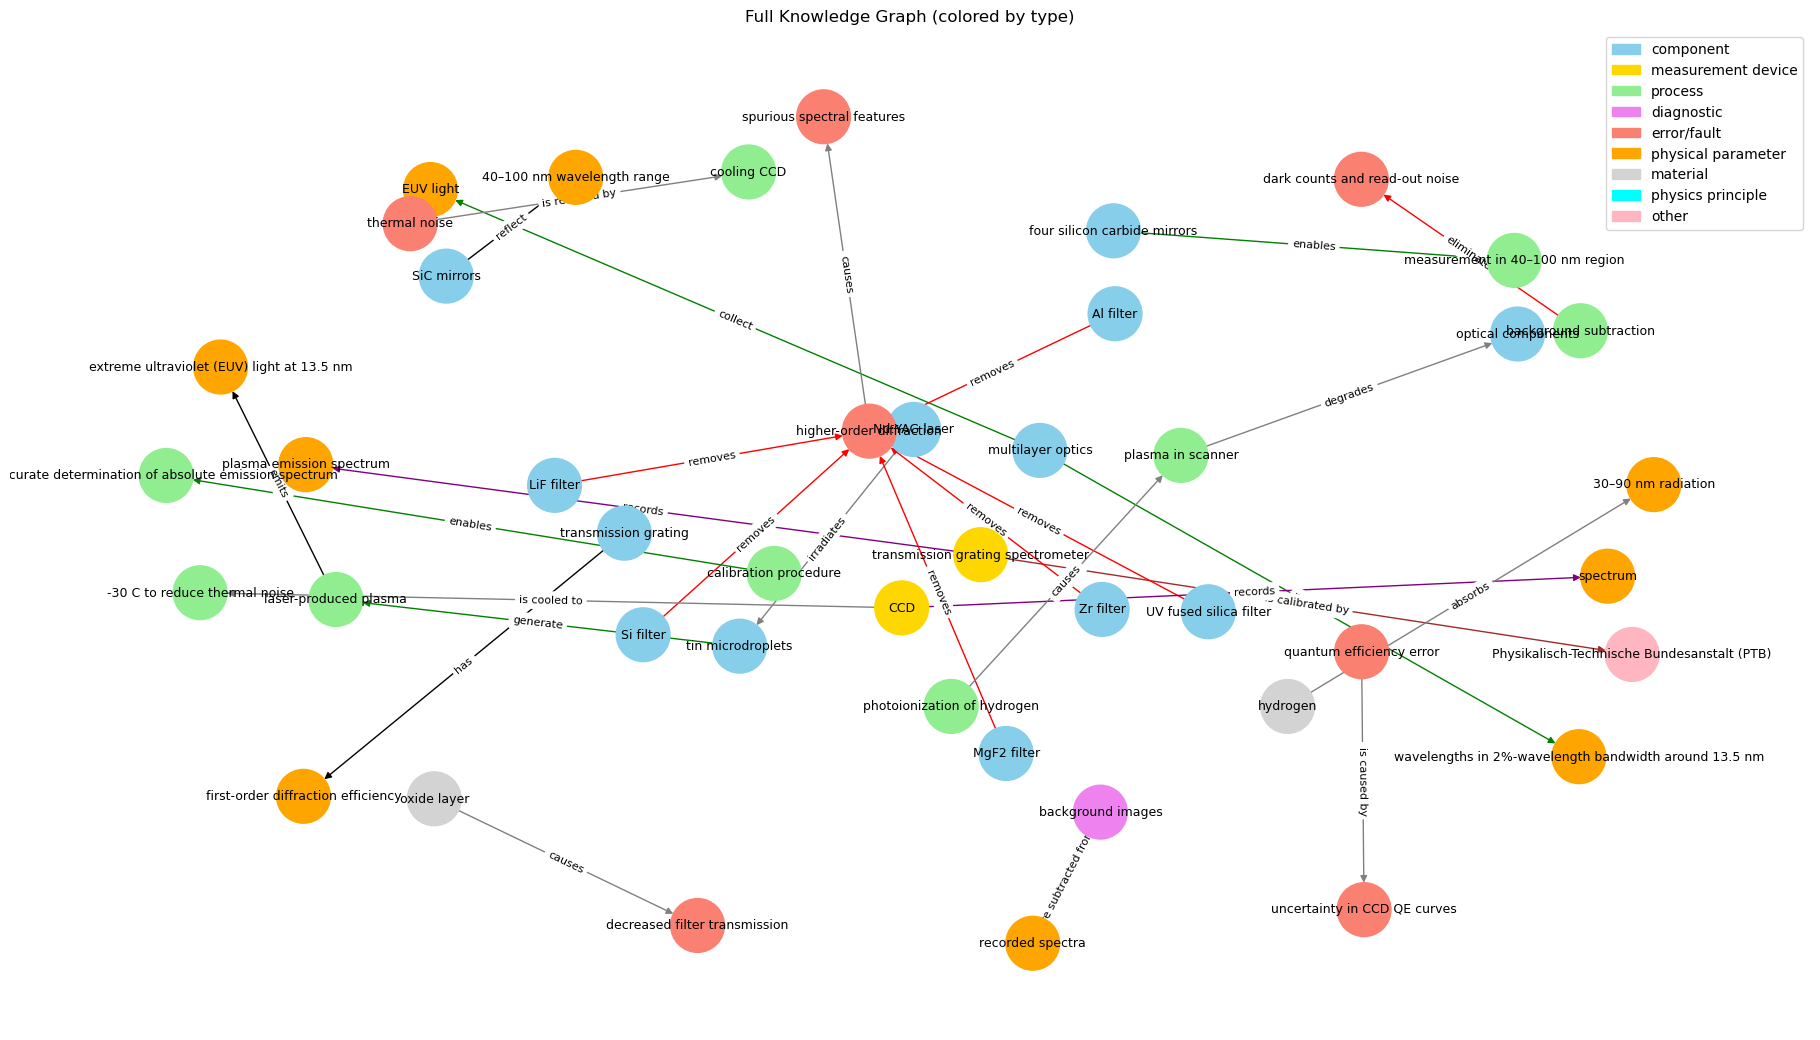

In [ ]:
plt.figure(figsize=(18, 10))
pos = nx.spring_layout(G, k=0.6, seed=42)  # fixed seed for reproducibility

nx.draw(
    G, pos,
    with_labels=True,
    node_color=node_colors,
    edge_color=edge_colors,
    node_size=1500,
    font_size=9
)
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
plt.title("Full Knowledge Graph (colored by type)")
plt.tight_layout()
legend_handles = [Patch(color=color, label=typ) for typ, color in type_color.items() if typ]
plt.legend(handles=legend_handles, bbox_to_anchor=(1, 1))
plt.show()

/var/folders/55/3_yjz_1s37vcxh8ld7nlc8k00000gn/T/ipykernel_38156/1900116071.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


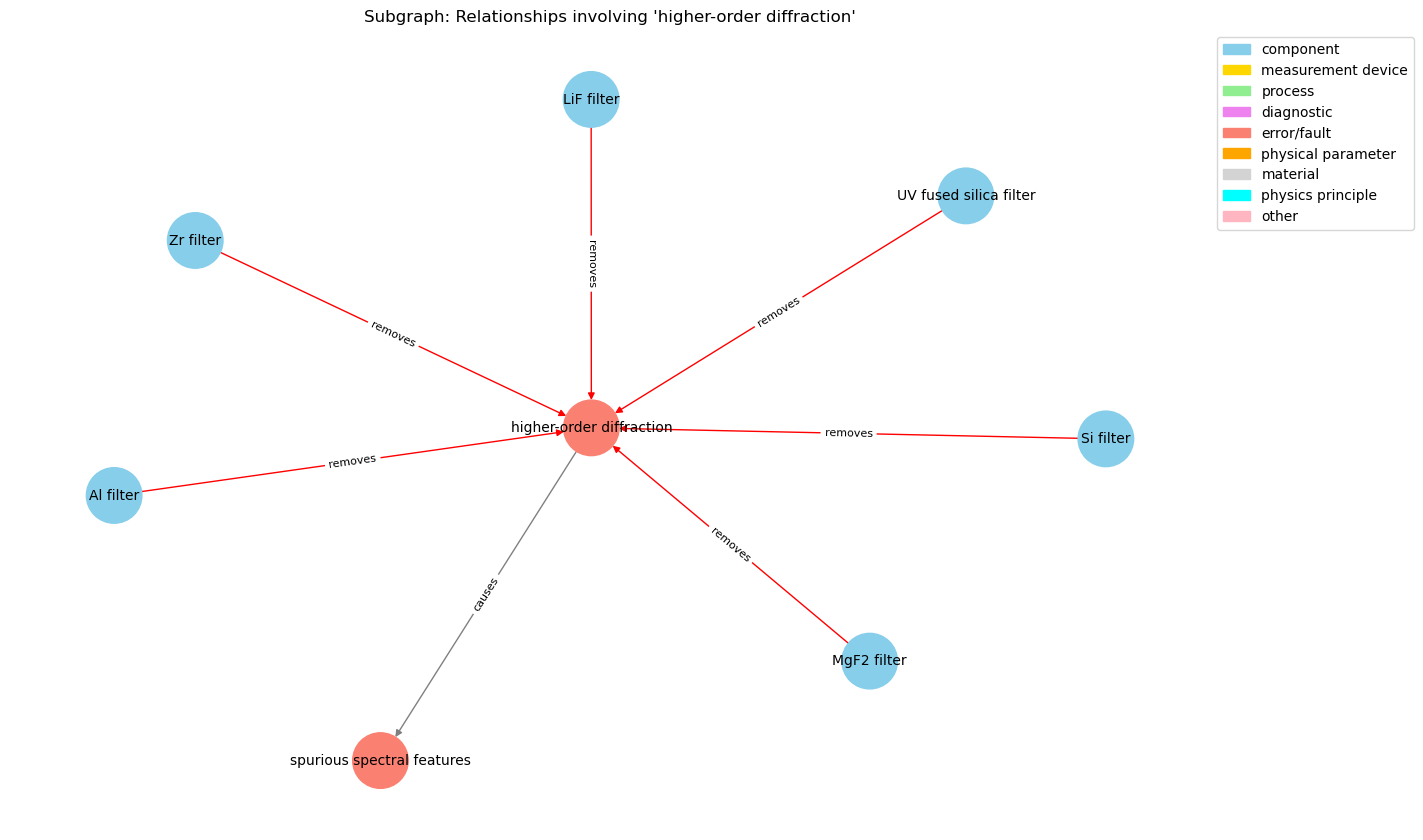

In [60]:
target_node = "higher-order diffraction"
sub_nodes = set([target_node])
for u, v in G.edges:
    if target_node in (u, v):
        sub_nodes.add(u)
        sub_nodes.add(v)
subG = G.subgraph(sub_nodes)
sub_node_colors = [type_color.get(subG.nodes[n].get("ntype"), "grey") for n in subG.nodes]
sub_edge_colors = [relation_color.get(subG.edges[e].get("rtype"), "grey") for e in subG.edges]

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(subG, k=0.6, seed=44)
nx.draw(
    subG, pos,
    with_labels=True,
    node_color=sub_node_colors,
    edge_color=sub_edge_colors,
    node_size=1600,
    font_size=10
)
edge_labels = nx.get_edge_attributes(subG, 'label')
nx.draw_networkx_edge_labels(subG, pos, edge_labels=edge_labels, font_size=8)
plt.title(f"Subgraph: Relationships involving '{target_node}'")
legend_handles = [Patch(color=color, label=typ) for typ, color in type_color.items() if typ]
plt.legend(handles=legend_handles, bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()